In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# First, install the library
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 17.0 MB/s eta 0:00:00


In [5]:
import medmnist
from medmnist import OrganAMNIST
import torch.utils.data as data
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(15),      # Rotate images slightly
    transforms.RandomHorizontalFlip(),  # Flip images left/right
    transforms.ToTensor()
])

# Keep test_transform simple (no random flips)
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = OrganAMNIST(split='train', transform=train_transform, download=True)
test_dataset = OrganAMNIST(split='test', transform=test_transform, download=True)

# Check the size
print(f"Training set size: {len(train_dataset)}")  # Output: ~34,581
print(f"Test set size: {len(test_dataset)}")    # Output: ~17,778
# (Plus validation set makes it ~58k total)

100%|██████████| 38.2M/38.2M [00:04<00:00, 7.89MB/s]


Training set size: 34561
Test set size: 17778


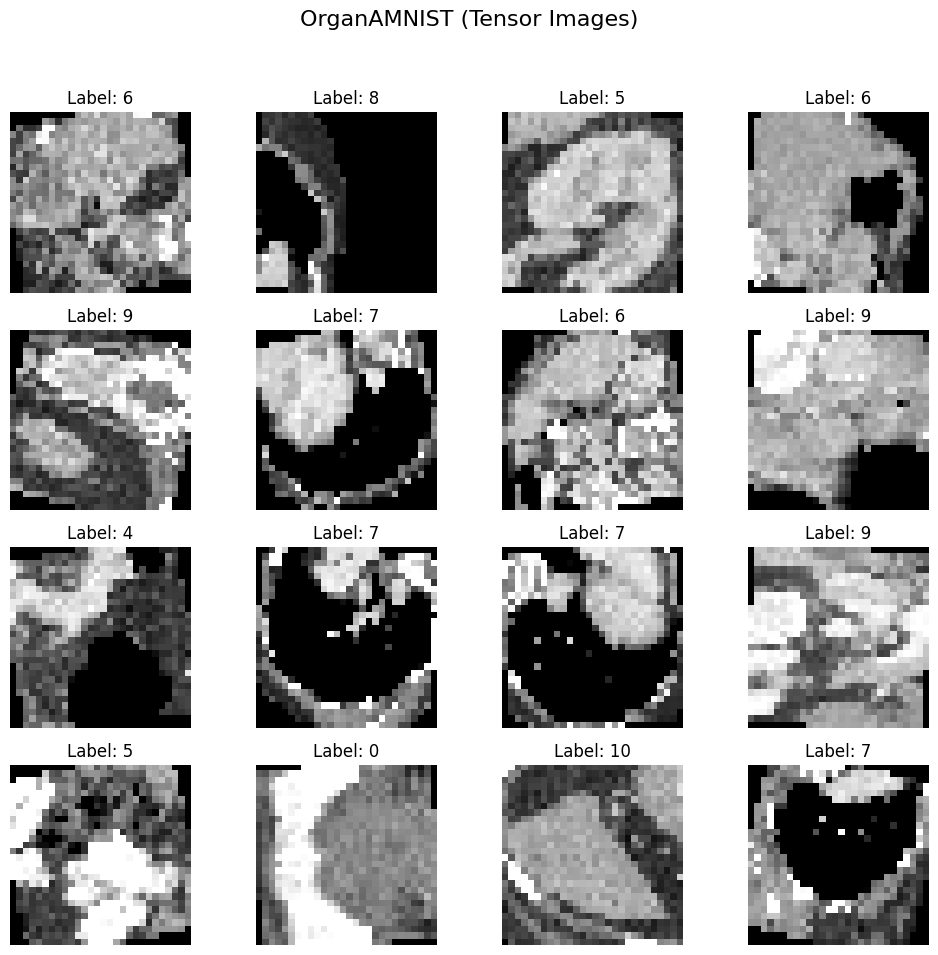

In [6]:
# 3. Create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("OrganAMNIST (Tensor Images)", fontsize=16)

# 4. Loop and Plot
for i, ax in enumerate(axes.flat):
    # Get the Tensor image and the label
    # img shape is [1, 28, 28] (Channels, Height, Width)
    img, label = train_dataset[i]

    # VITAL STEP: Remove the color channel for plotting
    # Changes shape from [1, 28, 28] -> [28, 28]
    image_for_plot = img.squeeze()

    # Plotting
    ax.imshow(image_for_plot, cmap='gray') # Use gray for medical scans
    ax.axis('off')

    # Label is inside a list (e.g., [3]), so we extract the item
    # .item() converts a tensor/array of one element to a standard Python number
    label_value = label[0].item() if hasattr(label[0], 'item') else label[0]
    ax.set_title(f"Label: {label_value}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True, pin_memory=True)

In [8]:
len(train_loader)

1080

In [23]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

            # --- Convolutional Block 1 ---
            # Input shape: [Batch, 1, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: [Batch, 32, 14, 14]
            nn.Dropout2d(p=0.25),

            # --- Convolutional Block 2 ---
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: [Batch, 64, 7, 7]
            nn.Dropout2d(p=0.25),

            # --- Convolutional Block 3 ---
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: [Batch, 128, 3, 3] (7 / 2 rounds down to 3)
            nn.Dropout2d(p=0.25),

            # --- Classification Head ---
            # Flatten the 2D maps into a 1D vector for the Linear layers
            nn.Flatten(),

            # 128 channels * 3 height * 3 width = 1152 features
            nn.Linear(128 * 3 * 3, 256),
            nn.BatchNorm1d(256), # Back to 1D Batch Norm
            nn.ReLU(),
            nn.Dropout(p=0.5),   # Standard 1D Dropout

            nn.Linear(256, 11)   # 11 output classes for OrganAMNIST
        )

    def forward(self, x):
        return self.model(x)


In [24]:
learning_rate = 0.01

In [25]:
# instatiate the model
model = MyCNN().to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate,weight_decay=1e-4)

In [26]:
# training loop
epochs = 30  # You can increase this back to 100 if you want

for epoch in range(epochs):
    total_epoch_loss = 0
    model.train() # Set model to training mode

    for batch_features, batch_labels in train_loader:
        # Move data to GPU
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # CRITICAL FIX FOR MEDMNIST:
        # MedMNIST labels come as shape [32, 1]. CrossEntropyLoss expects [32].
        # We use .squeeze() to remove the extra dimension.
        batch_labels = batch_labels.to(device).reshape(-1).long()

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch: 1, Loss: 1.1938
Epoch: 2, Loss: 0.7959
Epoch: 3, Loss: 0.6763
Epoch: 4, Loss: 0.6024
Epoch: 5, Loss: 0.5452
Epoch: 6, Loss: 0.5053
Epoch: 7, Loss: 0.4741
Epoch: 8, Loss: 0.4494
Epoch: 9, Loss: 0.4270
Epoch: 10, Loss: 0.4078
Epoch: 11, Loss: 0.3880
Epoch: 12, Loss: 0.3752
Epoch: 13, Loss: 0.3624
Epoch: 14, Loss: 0.3486
Epoch: 15, Loss: 0.3374
Epoch: 16, Loss: 0.3279
Epoch: 17, Loss: 0.3198
Epoch: 18, Loss: 0.3077
Epoch: 19, Loss: 0.3015
Epoch: 20, Loss: 0.2988
Epoch: 21, Loss: 0.2869
Epoch: 22, Loss: 0.2828
Epoch: 23, Loss: 0.2760
Epoch: 24, Loss: 0.2757
Epoch: 25, Loss: 0.2714
Epoch: 26, Loss: 0.2611
Epoch: 27, Loss: 0.2577
Epoch: 28, Loss: 0.2538
Epoch: 29, Loss: 0.2454
Epoch: 30, Loss: 0.2470


In [27]:
model.eval()# Set model to evaluation mode

MyCNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.25, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
   

In [28]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # Fix label shape here too
        batch_labels = batch_labels.to(device).reshape(-1).long()

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.9055


In [29]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # Fix label shape here too
        batch_labels = batch_labels.reshape(-1).long()

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.9720
